# Advanced vision applications

# Jeremy Howard

##  Deep Learning Part 2 2018

[Cutting edge deep learning for coders (2018) - wiki](https://forums.fast.ai/t/about-the-part-2-alumni-2018-category/13050)

[Cutting edge deep learning for coders (2018) - vidéos](https://www.youtube.com/watch?v=Z0ssNAbe81M&list=PLfYUBJiXbdtTttBGq-u2zeY1OTjs5e-Ia)

- 08 Object detection : http://course18.fast.ai/lessons/lesson8.html
- 09 Multi-object detection : http://course18.fast.ai/lessons/lesson9.html
- 12 Generative Adversarial Networks : http://course18.fast.ai/lessons/lesson12.html
- 13 Image enhancement & Style tranfer : http://course18.fast.ai/lessons/lesson13.html
- 14 Super resolution & Segmentation with UNet : http://course18.fast.ai/lessons/lesson14.html

# Zachary Mueller

## A walk with fastai2

https://github.com/muellerzr
    
[A walk with fastai2 (2020) - notebooks](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0)  

[A walk with fastai2 (2020) - vidéos](https://www.youtube.com/playlist?list=PLFDkaGxp5BXDvj3oHoKDgEcH73Aze-eET)

[A walk with fastai2 (2020) - forum](https://forums.fast.ai/t/a-walk-with-fastai2-vision-study-group-and-online-lectures-megathread/59929)

# Utilizing XResNet, it's ideas, and ImageWoof

In [0]:
#Run once per session
!pip install fastai2 -q

# Dataset:

Our dataset today will be ImageWoof. [Link](https://github.com/fastai/imagenette)

Goal: Using no pre-trained weights, see how well of accuracy we can get in x epochs

This dataset is generally harder than imagenette, both are a subset of ImageNet.

Models are leaning more towards being faster, more effecient

In [1]:
from fastai2.vision.all import *

Let's grab our data. For the competition, we'll focus on 5 epochs at 128x128

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

There are a few more datasets available:

* ImageNette: Slightly easier than ImageWoof, 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute)

* ImageWoof: 10 different dog breeds, Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog

* Image网 (Pronounced Imagewang, "net" in Chinese): Both ImageNette and Woof but:
  * The validation set is the same as Imagewoof (i.e. 30% of Imagewoof images); there are no Imagenette images in the validation set (they're all in the training set)
  * Only 10% of Imagewoof images are in the training set!
  * The remaining are in the unsup ("unsupervised") directory, and you can not use their labels in training!

We'll use the low-level `Dataset` API for this.

In [ ]:
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

Let's make our split

In [0]:
items = get_image_files(path)

In [0]:
split_idx = GrandparentSplitter(valid_name='val')(items)

Now let's build our `DataSet`

In [0]:
dsets = Datasets(items, tfms, splits=split_idx)

And our `DataLoaders`

In [0]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

Let's make sure we look okay

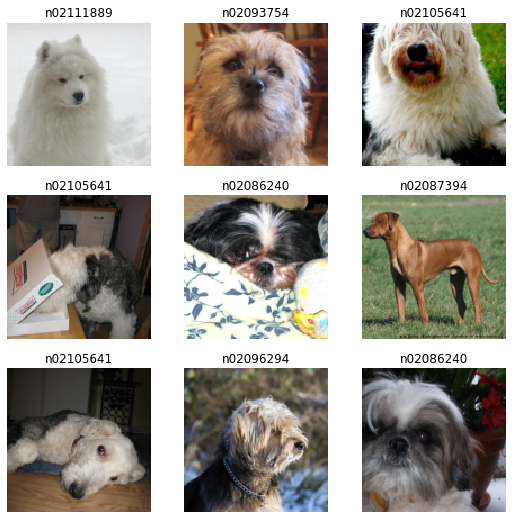

In [0]:
dls.show_batch()

Wait, those aren't species names! How do I get that readable?

* We can use a dictionary as a transform on our `y`'s

In [0]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

To do so we pass in the `__getitem__` attribute to our transforms

In [0]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]

In [0]:
dsets = Datasets(items, tfms, splits=split_idx)

In [0]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

Let's make sure it worked

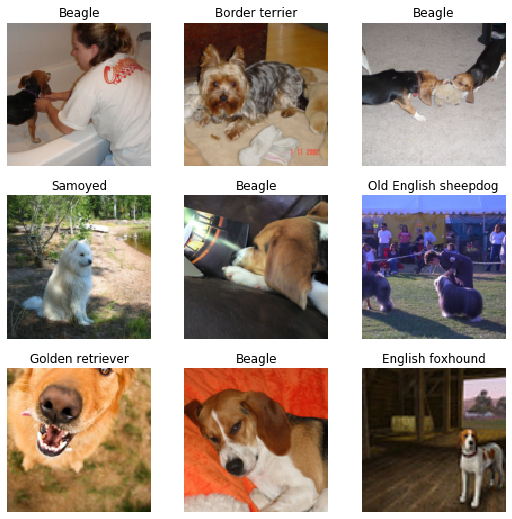

In [0]:
dls.show_batch()

Much better!

# The Architecture and the new Implementations

* XResNet - Based on the [Bag of Tricks for Resnet](https://arxiv.org/abs/1812.01187) paper
* [Mish](https://arxiv.org/abs/1908.08681v1) - A new activation function that has shown fantastic results
* Ranger - A new optimizer function based on two seperate papers:
  * [On the Varience of the Adaptive Learning rate and Beyond, RAdam](https://arxiv.org/abs/1908.03265)
  * [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/abs/1907.08610)
* [Self-Attention](https://arxiv.org/abs/1805.08318) - Bringing in ideas from GAN's into image classification (Incorportated by Seb)
* [MaxBlurPool](https://arxiv.org/pdf/1904.11486) - Better generalization
* Flatten + Anneal Scheduling - Mikhail Grankin
* [Label Smoothing Cross Entropy](https://arxiv.org/abs/1906.11567) - A threshold base (were you close) rather than yes or no


All of these ideas live in the library (except Dialated Convolutions for now). But where? Let's walk through it

XResNet50:

In [0]:
arch = xresnet50(pretrained=False)

After the `ImageWoof` competition, almost all of the above can simply be a setting in `xresnet`. 

## Mish:

In [0]:
arch = xresnet50(pretrained=False, act_cls=Mish)

In [0]:
arch[0]

ConvLayer(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)

## Self-Attention:

In [0]:
arch = xresnext50(pretrained=False, act_cls=Mish, sa=True)

## MaxBlurPool

In [0]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

### Model

In [0]:
net = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10)

In [0]:
net = convert_MP_to_blurMP(net, nn.MaxPool2d)

Now that we know how to use it all, let's test it out!

# Ranger + Fit-Flat-Cosine

In [0]:
opt_func = ranger

That is the same thing as:

In [0]:
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, lr=lr))

In [0]:
opt_func = opt_func

We'll also use Label Smoothing Cross Entropy as our loss

In [0]:
learn = Learner(dls, model=net, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy])

Finally let's find and fit our model

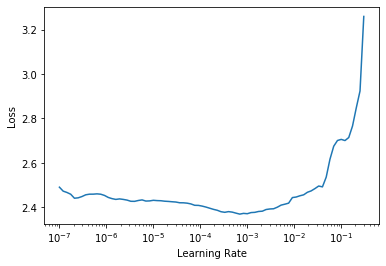

In [0]:
learn.lr_find()

And fit for 5 epochs! We want to use `fit_flat_cos` that Mikahil Grankin came up with. Why?

* We noticed gradient blow up. So instead of One-Cycle:

## One-Cycle vs Fit-Flat-Cosine

In [0]:
from fastai2.test_utils import synth_learner

In [0]:
synth = synth_learner()

In [0]:
synth.fit_one_cycle(1)

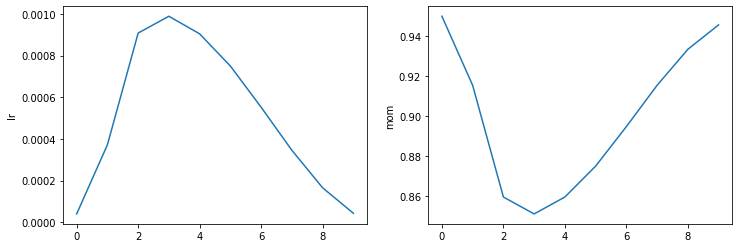

In [0]:
synth.recorder.plot_sched()

We fit with Cosine Annealing:

In [0]:
synth.fit_flat_cos(1, pct_start=0.72)

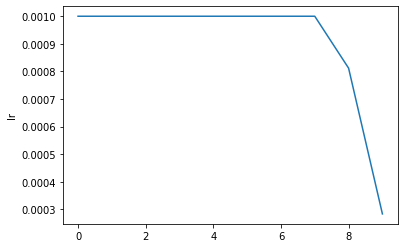

In [0]:
synth.recorder.plot_sched()

# Let's Train!

In [0]:
learn.fit_one_cycle(5, 4e-3)

# Image Segmentation

In [0]:
#Run once per session
!pip install fastai2 -q

What is segmentation?

* Pixel-wise classes
* Used for fine-grained image segmenting

![](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)
[URL](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)

![](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)
[URL](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)

# Libraries

In [0]:
from fastai2.vision.all import *

# Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road

In [0]:
path = untar_data(URLs.CAMVID)

Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:

In [0]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [0]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

Let's look at an image and see how everything aligns up

In [0]:
path_im = path/'images'
path_lbl = path/'labels'

First we need our filenames

In [0]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

And now let's work with one of them

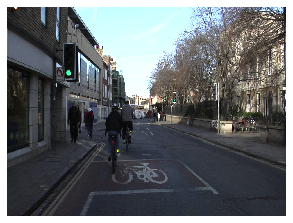

In [0]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_P`

In [0]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

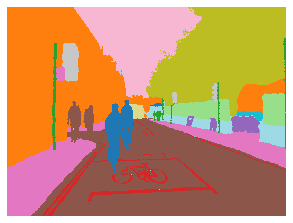

In [0]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [0]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own.

In [0]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames

# Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [0]:
sz = msk.shape; sz

(720, 960)

In [0]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [0]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [0]:
dls = camvid.dataloaders(path/'images', bs=8)

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

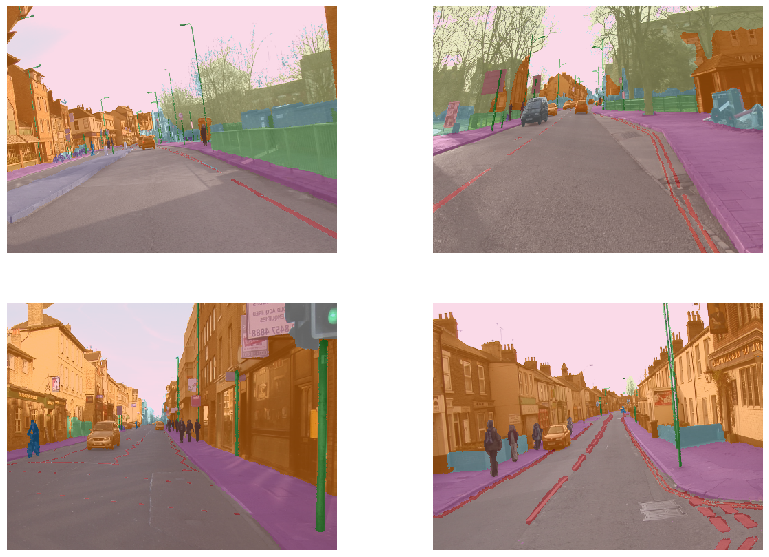

In [0]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [0]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [0]:
name2id = {v:k for k,v in enumerate(codes)}

In [0]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Awesome! Let's make an accuracy function

In [0]:
void_code = name2id['Void']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [0]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

## U-Net

![](http://deeplearning.net/tutorial/_images/unet.jpg)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in a configuration(`unet_config`) where we can declare a few things!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

In [0]:
config = unet_config(self_attention=True, act_cls=Mish)

Along with this we will use the `Ranger` as optimizer function.

In [0]:
opt = ranger

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 40.2MB/s]


In [0]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 360 x 480'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 180 x 240   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 180 x 240   128        True      
________________________________________________________________
ReLU                 8 x 64 x 180 x 240   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 90 x 120    0          False     
________________________________________________________________
Conv2d               8 x 64 x 90 x 120    36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 90 x 120    128        True      
________________________________________________________________
ReLU                 8 x 64 x 90 x 120    0          False     
_________________________________________________

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

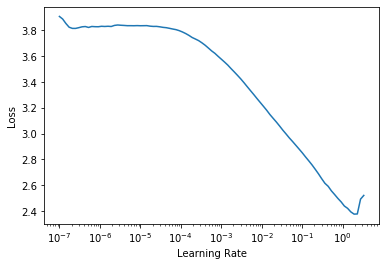

In [0]:
learn.lr_find()

In [0]:
lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [0]:
learn.fit_flat_cos(10, slice(lr))

In [0]:
learn.save('stage-1')
learn.load('stage-1');

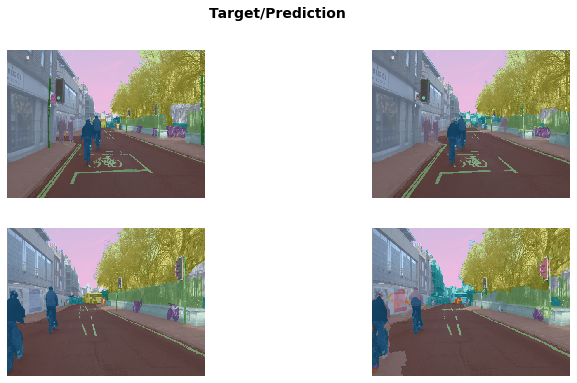

In [0]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [0]:
lrs = slice(lr/400, lr/4)

In [0]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [0]:
learn.unfreeze()

And train for a bit more

In [0]:
learn.fit_flat_cos(12, lrs)

Now let's save that model away

In [0]:
learn.save('model_1')

And look at a few results

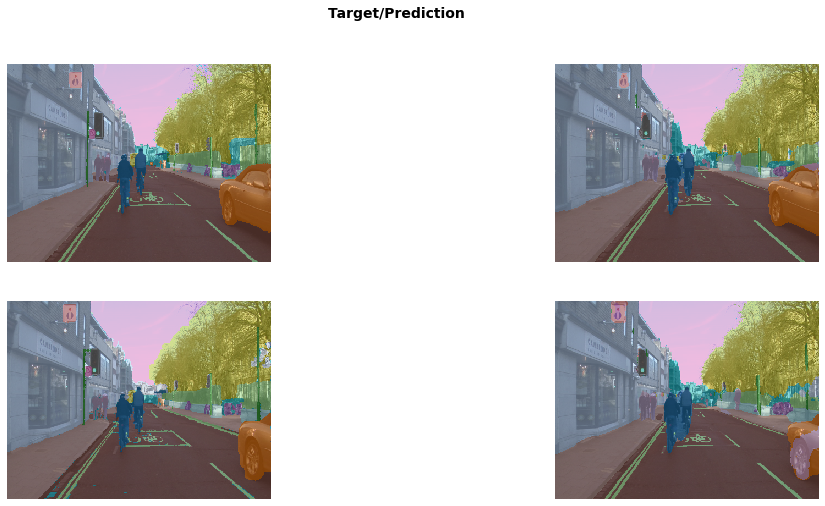

In [0]:
learn.show_results(max_n=4, figsize=(18,8))

# Inference

Let's take a look at how to do inference with `test_dl`

In [0]:
dl = learn.dls.test_dl(fnames[:5])

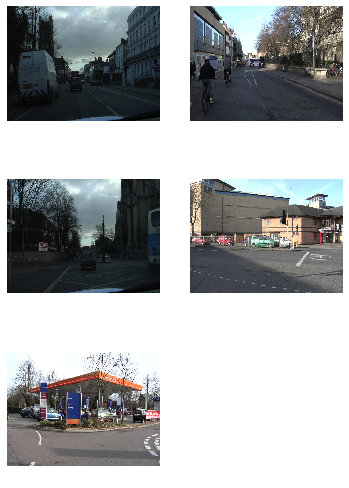

In [0]:
dl.show_batch()

Let's do the first five pictures

In [0]:
preds = learn.get_preds(dl=dl)

In [0]:
preds[0].shape

torch.Size([5, 32, 360, 480])

Alright so we have a 5x32x360x480

In [0]:
len(codes)

32

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first

In [0]:
pred_1 = preds[0][0]

In [0]:
pred_1.shape

torch.Size([32, 360, 480])

Now let's take the argmax of our values

In [0]:
pred_arx = pred_1.argmax(dim=0)

And look at it

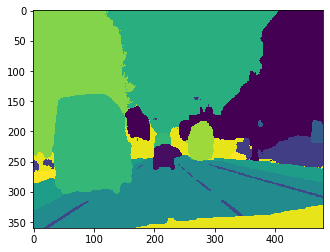

In [0]:
plt.imshow(pred_arx)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)

In [0]:
pred_arx = pred_arx.numpy()

In [0]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [0]:
im = Image.fromarray(rescaled)

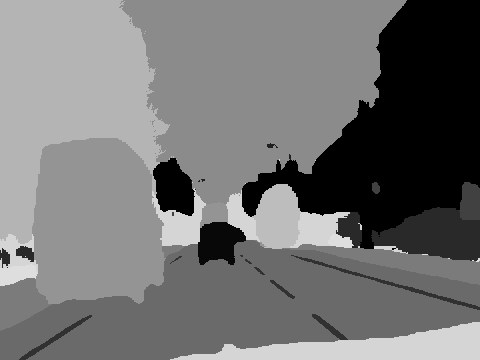

In [0]:
im

In [0]:
im.save('test.png')

Let's make a function to do so for our files

In [0]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

Now let's save away the raw:

In [0]:
torch.save(preds[0][0], 'Image_1.pt')

In [0]:
pred_1 = torch.load('Image_1.pt')

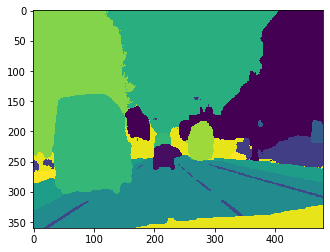

In [0]:
plt.imshow(pred_1.argmax(dim=0))

# Full Size (Homework)

Now let's go full sized. Restart your instance to re-free your memory

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [0]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def ListSplitter(items):
  def _inner(it):
    val_mask = tensor([o.name in items for o in it])
    return [~val_mask, val_mask]
  return _inner

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our dataloaders. But this time we want our size to be the full size

In [0]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

We'll also want to lower our batch size to not run out of memory

In [0]:
dls = camvid.dataloaders(path/"images", bs=1)

Let's assign our vocab, make our learner, and load our weights

In [0]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)
learn.load('model_1');

And now let's find our learning rate and train!

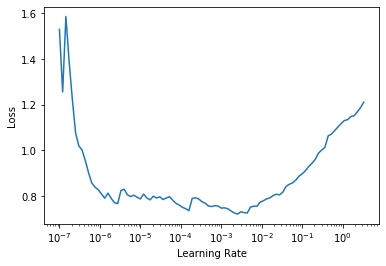

In [0]:
learn.lr_find()

In [0]:
lr = 1e-3

In [0]:
learn.fit_flat_cos(10, slice(lr))

In [0]:
learn.save('full_1')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 0.0001, None)

In [0]:
learn.fit_flat_cos(10, lrs)

In [0]:
learn.save('full_2')

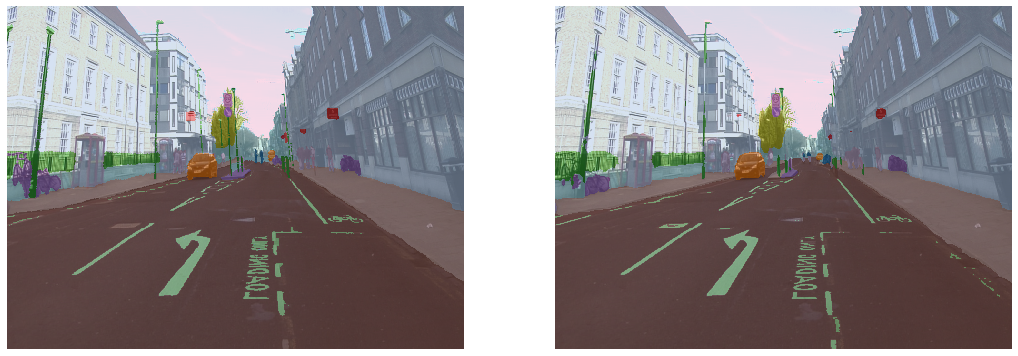

In [0]:
learn.show_results(max_n=4, figsize=(18,8))

# Weighted Loss Functions

We can use weighted loss functions to help with class imbalancing. We need to do this because simply oversampling won't quite work here! So, how do we do it? `fastai2`'s `CrossEntropyLossFlat` is just a wrapper around `PyTorch`'s `CrossEntropyLoss`, so we can pass in a `weight` parameter (even if it doesn't show up in our autocompletion!) 




In [0]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

But what should this weight be? It needs to be a 1x`n` tensor, where `n` is the number of classes in your dataset. We'll use a quick example, where all but the last class has a weight of 90% and the last class has a weight of 110%

Also, as we are training on the GPU, we need the tensor to be so as well:

In [0]:
weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()

In [0]:
weights

tensor([[0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 1.1000]], device='cuda:0')

Now we can pass this into `CrossEntropyLossFlat`

* **Note**: as this is segmentation, we need to make the axis to 1

In [0]:
learn.loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

(or to pass it into `cnn_learner`)

In [0]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, loss_func=loss_func)

In [0]:
#default_exp style_transfer

Before we run anything we want to ensure we have a P100 GPU:

In [0]:
!nvidia-smi

Sat Feb 15 20:18:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    36W / 250W |   1795MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

If not, run the following:

(NOTE: This may change due to Colab's new policy)

In [0]:
import torch
data = torch.ones(1000,1000,1000).cuda()

# 05 - Style Transfer
**This notebook is largely based on the work by Lucas Vazquez on the fastai forum**

## What will we cover?

* Custom loss functions
* Custom models
* Utilizing the `nb_dev` library
* Deployment Code

# Intro to `nbdev`

* Library by Jeremy and Sylvain for writing libraries
* Used to make the entire `fastai2` library
* Converts a `ipynb` to documentation as well as `.py` with **only specific cells**

* Few base terminology:
  * `#default_exp`
  * `#hide`
  * `#export`

In [0]:
#hide
#Run once per session
!pip install fastai2

In [0]:
#hide
from nbdev.showdoc import *

We always need the `showdoc` to export

# fastai2 libraries

In [0]:
#export
from fastai2.vision.all import *

# What is Style Transfer?

* **Feature Loss**
  * Aka perception loss
* **Image Transformation network**
  * Input images -> Output images
* **Pre-Trained Loss Network**
  * **Perceptual loss functions** 
    * A measurement of the differences in content and style between two images
    
![alt text](https://miro.medium.com/max/1436/0*iwXnji_6lny5slPo)

Source: https://arxiv.org/abs/1603.08155

# Our Pre-Trained Network:
* vgg-19:
  * Small CNN pre-trained on ImageNet
  * Only 19 layers deep

In [0]:
#export
from torchvision.models import vgg19, vgg16

In [0]:
feat_net = vgg19(pretrained=True).features.cuda().eval()

We'll get rid of the head and use the internal activations (and our generator model's loss). As a result, we want to set every layer to un-trainable

In [0]:
for p in feat_net.parameters(): p.requries_grad=False

We will be using feature detections that our model picks up, which is like our heatmaps generated for our Classification models

In [0]:
layers = [feat_net[i] for i in [1, 6, 11, 20, 29, 22]]; layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

The outputs are `ReLU` layers. Below is a configuration for the 16 and 19 models

In [0]:
#export
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

Let's write a quick `get_layers` function to grab our network and the layers

In [0]:
#export 
def _get_layers(arch:str, pretrained=True):
  "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
  feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
  config = _vgg_config.get(arch)
  features = feat_net.features.cuda().eval()
  for p in features.parameters(): p.requires_grad=False
  return feat_net, [features[i] for i in config]

Now let's make it all in one go utilizing our private functions to pass in an architecture name and a `pretrained` parameter

In [0]:
#export
def get_feats(arch:str, pretrained=True):
  "Get the features of an architecture"
  feat_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    feat_net(x)
    return hooks.stored
  return _inner

In [0]:
feats = get_feats('vgg19')

# The Loss Function


Our loss fuction needs:

* Our original image
* Some artwork / style
* Activation features from our encoder

What image will we be using?

![alt text](https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg)

Let's grab the image

In [0]:
#export
url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

In [0]:
!wget {url} -O 'style.jpg'

--2020-02-15 20:18:14--  https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg
Resolving static.greatbigcanvas.com (static.greatbigcanvas.com)... 3.212.96.207, 52.73.94.154
Connecting to static.greatbigcanvas.com (static.greatbigcanvas.com)|3.212.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445921 (435K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 435.47K  --.-KB/s    in 0.04s   

2020-02-15 20:18:14 (9.65 MB/s) - ‘style.jpg’ saved [445921/445921]



In [0]:
fn = 'style.jpg'

We can now make a `PipeLine` to convert our image into a `Tensor` to use in our loss function. We'll want to use the `Datasets` for this

In [0]:
dset = Datasets(fn, tfms=[PILImage.create])

In [0]:
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

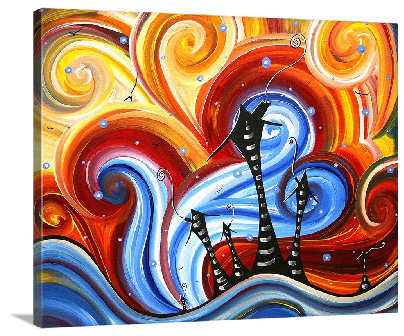

In [0]:
dl.show_batch(figsize=(7,7))

In [0]:
style_im = dl.one_batch()[0]

In [0]:
style_im.shape

torch.Size([1, 3, 824, 1000])

In [0]:
#export
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
  return dl.one_batch()[0]

We can then grab the features using our `feats` function we made earlier

In [0]:
im_feats = feats(style_im)

Let's look at their sizes

In [0]:
for feat in im_feats:
  print(feat.shape)

torch.Size([1, 64, 824, 1000])
torch.Size([1, 128, 412, 500])
torch.Size([1, 256, 206, 250])
torch.Size([1, 512, 103, 125])
torch.Size([1, 512, 51, 62])
torch.Size([1, 512, 103, 125])


Now we can bring those images down to the channel size

In [0]:
#export
def gram(x:Tensor):
  "Transpose a tensor based on c,w,h"
  n, c, h, w = x.shape
  x = x.view(n, c, -1)
  return (x @ x.transpose(1, 2))/(c*w*h)

In [0]:
im_grams = [gram(f) for f in im_feats]

In [0]:
for feat in im_grams:
  print(feat.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [0]:
#export
def get_stl_fs(fs): return fs[:-1]

We're almost there! Let's look at why that was important

In [0]:
#export
def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  # Get batch size
  bs = inp[0].shape[0]
  loss = []
  # For every item in our inputs
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    # Calculate MSE
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000
  return 3e5 * sum(loss)

Great, so what now? Let's make a loss function for `fastai2`!
* Remember, we do not care to use any initial metrics

In [0]:
#export
class FeatureLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, feats, style_loss, act_loss):
    store_attr(self, 'feats, style_loss, act_loss')
    self.reset_metrics()

  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_feat, targ_feat = self.feats(pred), self.feats(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_feat, targ_feat)
    act_loss = self.act_loss(pred_feat, targ_feat)
    # Store the loss
    self._add_loss(style_loss, act_loss)
    # Return the sum
    return style_loss + act_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, act_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(act_loss)

In [0]:
#export
def act_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

Let's declare our loss function by passing in our features and our two 'mini' loss functions

In [0]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

# The Model Architecture
Let's now build our model

In [0]:
#export
class ReflectionLayer(Module):
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [0]:
ReflectionLayer(3, 3)

ReflectionLayer(
  (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
  (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2))
)

In [0]:
#export
class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
          self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in1 = nn.InstanceNorm2d(channels, affine=True)
          self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in2 = nn.InstanceNorm2d(channels, affine=True)
          self.relu = nn.ReLU()

    def forward(self, x):
          residual = x
          out = self.relu(self.in1(self.conv1(x)))
          out = self.in2(self.conv2(out))
          out = out + residual
          return out

In [0]:
ResidualBlock(3)

ResidualBlock(
  (conv1): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in1): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU()
)

In [0]:
#export
class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

Let's put everything together into a model

In [0]:
#export
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [0]:
net = TransformerNet()

# DataLoaders and Learner

We will be using the `COCO_SAMPLE` dataset

In [0]:
path = untar_data(URLs.COCO_SAMPLE)

Our `DataBlock` needs to be Image -> Image

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

If you do not pass in a `get_y`, `fastai2` will assume your input = output

In [0]:
dls = dblock.dataloaders(path, bs=22)

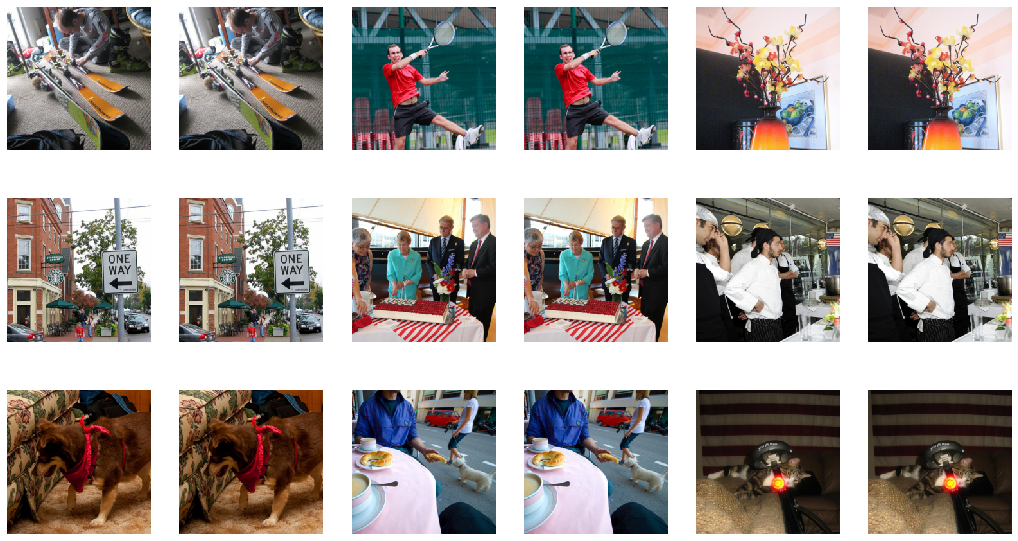

In [0]:
dls.show_batch()

We now can make our `Learner`!

In [0]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

In [0]:
learn.summary()

TransformerNet (Input shape: ['22 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
ReflectionPad2d      22 x 3 x 232 x 232   0          False     
________________________________________________________________
Conv2d               22 x 32 x 224 x 224  7,808      True      
________________________________________________________________
InstanceNorm2d       22 x 32 x 224 x 224  64         True      
________________________________________________________________
ReflectionPad2d      22 x 32 x 226 x 226  0          False     
________________________________________________________________
Conv2d               22 x 64 x 112 x 112  18,496     True      
________________________________________________________________
InstanceNorm2d       22 x 64 x 112 x 112  128        True      
________________________________________________________________
ReflectionPad2d      22 x 64 x 114 x 114  0          False     
_____________________________________________

Let's find a learning rate and fit for one epoch

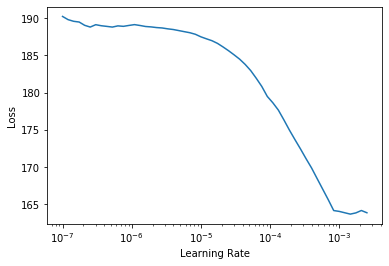

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(1, 1e-3)

And take a look at some of our results!

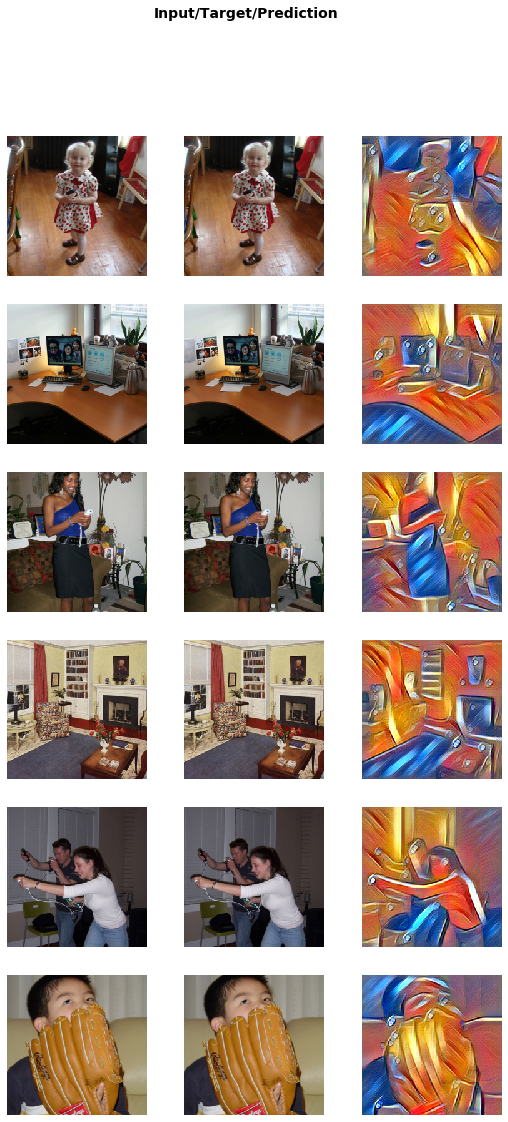

In [0]:
learn.show_results()

In [0]:
learn.save('stage1')

Now let's try `learn.predict`

In [0]:
pred = learn.predict('cat.jpg')

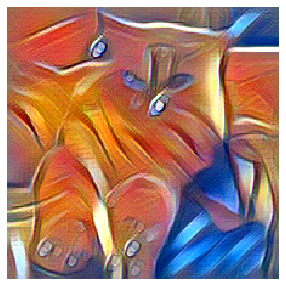

In [0]:
pred[0].show()

Well while that looks cool, we lost a lot of the features! How can we fix this? Let's try something similar to what we did for our `style_im`

In [0]:
learn.load('stage1')

In [0]:
dset = Datasets('cat.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

In [0]:
t_im = dl.one_batch()[0]

In [0]:
with torch.no_grad():
  res = learn.model(t_im)

Now let's try that again

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


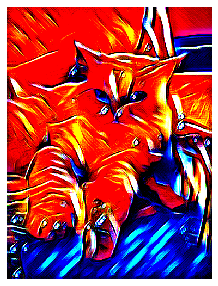

In [0]:
TensorImage(res[0]).show()

Much better!

In [0]:
learn.save('224')

Now we can increase our size to 512 similar to how we could do in the segmentation example (this is homework, we will not do this as the epoch will take ~40 minutes)

# Homework

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(448)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [0]:
dls = dblock.dataloaders(path, bs=8)

In [0]:
learn = Learner(dls, net, loss_func=loss_func).load('224')

In [0]:
learn.fit_one_cycle(1, 1e-3)

In [0]:
learn.show_results()

In [0]:
learn.save('final')

# Rest of the lesson

Let's export our model to use.

In [0]:
learn.loss_func = CrossEntropyLossFlat()

In [0]:
learn.export('myModel')

From here:
Download the notebook and upload it to the main

# Export

In [0]:
#hide
from nbdev.imports import *
from nbdev.export import reset_nbdev_module, notebook2script

create_config('myLib', user='muellerzr', path='.', cfg_name='settings.ini')
cfg = Config(cfg_name='settings.ini')

In [0]:
reset_nbdev_module()

In [0]:
#hide
from nbdev.export import notebook2script
notebook2script('05_StyleTransfer.ipynb')

Converted 05_StyleTransfer.ipynb.


# 05 EfficientNet and Custom Pretrained Models

This notebook will cover:
* Using a `PyTorch` model
* Using pre-trained weights for transfer learning
* Setting up a `cnn_learner` style `Learner`

## The Problem:

The problem today will be a familiar one, `PETs`, as we are going to focus on the `Learner` instead

In [0]:
#Run once per session
!pip install fastai2 -q

In [0]:
from fastai2.vision.all import *

Let's make our usual dataloaders real quick

In [0]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

In [0]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [0]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [0]:
dls = pets.dataloaders(path, bs=bs)

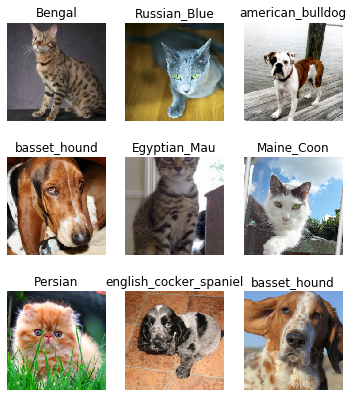

In [0]:
dls.show_batch(max_n=9, figsize=(6,7))

Now let's focus on our `EfficentNet` model. We'll be working out of Ross Wightman's repository [here](https://github.com/rwightman/pytorch-image-models). Included in this repository is tons of pretrained models for almost every major model in Computer Vision. All were for 224x224 training and validation size. Let's install it

In [0]:
!pip install timm

     |████████████████████████████████| 143kB 2.8MB/s 


Now we can then use his weights one of two ways. First we'll show the direct way to load it in, then we'll load in the weights ourselves

In [0]:
from timm import create_model

In [0]:
net = create_model('efficientnet_b3a', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


Now let's take a look at our downloaded model, so we know how to modify it for transfer learning. With fastai models we can do something like so:

In [0]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.2MB/s]


In [0]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

And we see this head of our model! Let's see if we can do this for our `EfficientNet`

In [0]:
net[-1]

TypeError: ignored

No! Why?

In [0]:
len(learn.model)

2

In [0]:
len(net)

TypeError: ignored

We can see that our `fastai2` model was **split** into two different layer groups:

* Group 1: Our encoder, which is everything but the last layer of our original model
* Group 2: Our head, which is a `fastai2` version of a `Linear` layer plus a few extra bits

In [0]:
create_head(2048, 10)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

How do we do this for our model? Let's take a look at it:

In [0]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Swish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )

We can see that our `Pooling` layer and our `Linear` layer is the last two layers of our model. Let's pop those off

Now if we use the original `fastai2` `create_body` function, we'll get an error:

In [0]:
body = create_body(net, pretrained=False, cut=-1)

TypeError: ignored

Why? Let's take a look

In [0]:
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

We can see that arch needs to be a **generator**. Let's try to make a function to help us with specifically his library

In [0]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")

Let's try it out!

In [0]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [0]:
len(body)

7

Now we can see that we have seven seperate groups

In [0]:
body

Sequential(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Swish()
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwis

But we've popped off the last layers we need! Let's move onto our head of the model. We know the input should be `3072` (we can see this in the last linear layer of the original model). We need it 2x it because of our `AdaptiveConcatPooling` We want it to have an output to our classes. But what if we dont' know that?

In [0]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf

3072

In [0]:
head = create_head(nf, dls.c)

In [0]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

Now finally we need to wrap it together

In [0]:
model = nn.Sequential(body, head)

And then we initialize our new head of our model

In [0]:
apply_init(model[1], nn.init.kaiming_normal_)

Now we have our two layer-long model! What's next?

In [0]:
len(model)

2

Let's try making a `Learner`

In [0]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [0]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 112 x 112  1,080      True      
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 40 x 112 x 112  360        True      
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

Oh no! It isn't frozen, what do we do? We never split the model! Since we have it set to where `model[0]` is the first group and `model[1]` is the second group, we can use the `default_split` splitter. Let's try again

In [0]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate)

In [0]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 112 x 112  1,080      False     
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 40 x 112 x 112  360        False     
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

That looks much better. Let's train!

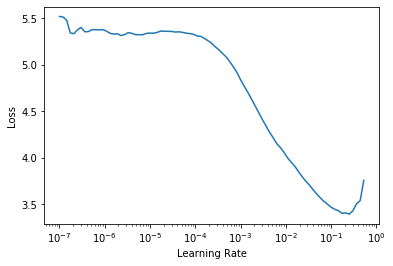

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, slice(3e-2))

In [0]:
learn.save('stage_1')

Then we can unfreeze it and train a little more

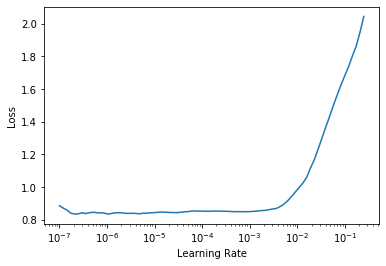

In [0]:
learn.unfreeze()
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, 1e-4)

In [0]:
learn.save('model_2')

One of the hardest parts about training the `EfficientNet` models is figuring out how to find the right learning rate that won't break everything, so choose cautiously and always a bit lower than what you may want to use after unfreezing

We barely under-matched our Resnet34, **but** we're using a model that is **57%** the size of the Resnet34!

# Pretrained PKL File

Let's say we have a different situation:

* No "pretrained=True"
* Have downloaded weights

* Possible scenarios:
  * Experimenting with a model 
  * Transfer learning twice

How do we do it? Let's take our Cats and Dogs model and train ImageWoof off of it

In [0]:
path = untar_data(URLs.IMAGEWOOF)
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [0]:
items = get_image_files(path)
split_idx = GrandparentSplitter(valid_name='val')(items)
dsets = Datasets(items, tfms, splits=split_idx)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

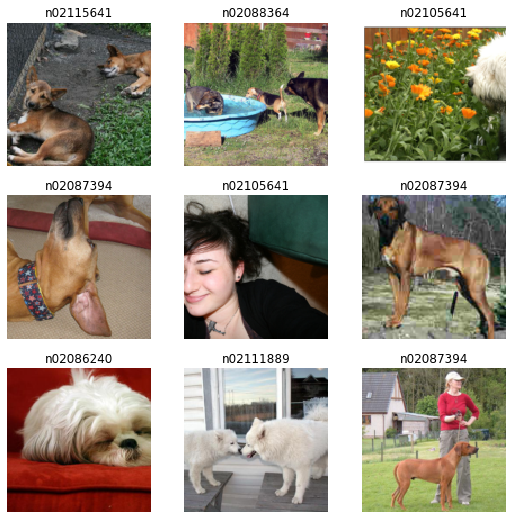

In [0]:
dls.show_batch()

Let's walk through how we would do that. First let's grab our model and make our `Learner` like we did before, with **everything** but the pretraining!

In [0]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(3072, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [0]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)

Now, remember these are all random weights right now. How do we change this? We look at the `state_dict`

In [0]:
learn.model.state_dict()

The state dict tells us the parameters and weights at **every** layer. Now to work with it, we'll borrow some code from [viraat](https://forums.fast.ai/t/loading-pretrained-weights-that-are-not-from-imagenet/28821/3). Basically what we want to do is:
1. Keep two state_dict's, one of our new model and one of the old
2. If a layer matches, copy the weights
3. Move until there are no more layers
4. Finally load the new state_dict generated

In [0]:
learn.model_dir

'models'

In [0]:
def transfer_learn(learn:Learner, name:Path, device:torch.device=None):
    "Load model `name` from `self.model_dir` using `device`, defaulting to `self.dls.device`."
    if device is None: device = learn.dls.device
    learn.model_dir = Path(learn.model_dir)
    if (learn.model_dir/name).with_suffix('.pth').exists(): model_path = (learn.model_dir/name).with_suffix('.pth')
    else: model_path = name
    new_state_dict = torch.load(model_path, map_location=device)['model']
    learn_state_dict = learn.model.state_dict()
    for name, param in learn_state_dict.items():
        if name in new_state_dict:
            input_param = new_state_dict[name]
            if input_param.shape == param.shape:
                param.copy_(input_param)
            else:
                print('Shape mismatch at:', name, 'skipping')
        else:
            print(f'{name} weight of the model not in pretrained weights')
    learn.model.load_state_dict(learn_state_dict)
    return learn

Now let's load some in!

In [0]:
learn = transfer_learn(learn, 'stage_1')

Shape mismatch at: 1.8.weight skipping


In [0]:
learn.model[1][8]

Linear(in_features=512, out_features=10, bias=False)

And we can see the only weight that wasn't loaded in was our new layer! Let's freeze and train our model

In [0]:
learn.freeze()

Let's see if it worked. We'll do a comparison test, 5 epochs without our `transfer_learn` and five with

In [0]:
learn.fit_one_cycle(5, 3e-3)

And now let's try on a regular non-transfered learner (at the same learning rate, frozen, etc)

In [0]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(3072, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)
learn.freeze()
learn.fit_one_cycle(5, 3e-3)

In [0]:
#Run once per session
!pip install fastai2 -q

# Object Detection

Finding the localized area in which an object presides from two points, the bottom left and top right

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/maxresdefault.jpg)

# The Data

Before we begin training, let's focus on how to build the `DataLoader`. We'll want to use the `Pascal_VOC` dataset today

In [0]:
from fastai2.vision.all import *

In [0]:
path = untar_data(URLs.PASCAL_2007)

Now how do we get our labels? `fastai2` has a `get_annotations` function that we can use to grab the image and their bounding box. The one-line documentation states:
"Open a COCO style json in `fname` and returns the list of filenames (with mabye `prefix`) and labelled bounding boxes."

In [0]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json')]

We'll want to read out of the `train.json`

In [0]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [0]:
imgs[0]

'000012.jpg'

In [0]:
lbl_bbox[0]

([[155, 96, 351, 270]], ['car'])

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [0]:
img2bbox = dict(zip(imgs, lbl_bbox))

Let's check the first item

In [0]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [0]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

For our transforms, we'll use some of the ones we defined earlier

In [0]:
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [0]:
def get_train_imgs(noop):  return imgs

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [0]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [0]:
dls = pascal.dataloaders(path/'train')

In [0]:
dls.c = 20

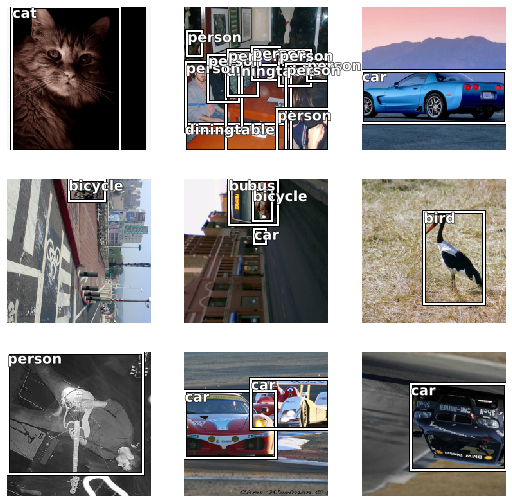

In [0]:
dls.show_batch()

# The Model

The architecture we are going to use is called `RetinaNet`. I've exported this all myself for you guys to use quickly, if you want to explore what's going on in the code I'd recommend the Object Detection lesson [here](https://www.youtube.com/watch?v=Z0ssNAbe81M&t=4496s)

Let's clone my repo and work out of it

In [0]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

/content/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [0]:
from imports import *

We're still going to use transfer learning here by creating an `encoder` (body) of our model and a head

In [0]:
encoder = create_body(resnet34, pretrained=True)

Now that we have our encoder, we can call the `RetinaNet` architecture. We'll pass in the encoder, the number of classes, and what we want our final bias to be on the last convolutional layer (how we initialize our model). Jeremy has his example at -4 so let's use this

In [0]:
get_c(dls)

20

In [0]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

Another big difference is the head of our model. Instead of our linear layers with pooling layers:

In [0]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a `box_regressor` (to get our points)

In [0]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [0]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [0]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Loss Function
Now we can move onto our loss function. For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be. The paper used [1,2**(1/3), 2**(2/3)], but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead. We will need these for inference later!

In [0]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

Let's make our loss function, which is `RetinaNetFocalLoss`

In [0]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Now let's make our `Learner`!

We want to freeze our `encoder` and keep everything else unfrozen to start

In [0]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [0]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [0]:
learn.freeze()

In [0]:
learn.summary()

RetinaNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
__________________________________________________

We can see it was split and frozen by looking at the summary!

Now let's train!

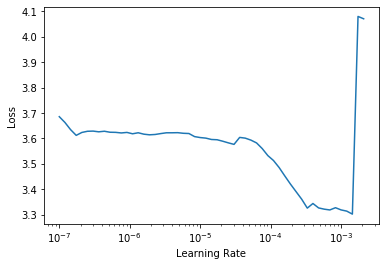

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

# 06 Multimodal Learning - Bengali.AI

* We'll cover how to build a multimodal vision model for the [Bengali.AI](https://www.kaggle.com/c/bengaliai-cv19) competition

### The Problem:

* Given one handwritten Bengali grapheme, seperately classify three constituent elements:
  * Grapheme root
  * Vowel diacritics
  * Consonant diacritics

This notebook assumes you've already joined the competition and have downloaded the dataset to a `zip` file called "bengaliai.zip"

In [0]:
from zipfile import ZipFile
with ZipFile('bengaliai.zip', 'r') as zip_ref:
  zip_ref.extractall('bengaliai')

# Data Prep:

We need to preprocess the data to make it easier to work with in the framework. We'll use [iafoss](https://www.kaggle.com/iafoss)' example found in [this](https://www.kaggle.com/iafoss/image-preprocessing-128x128) notebook

In [0]:
height = 137
width = 236
size = 128

The data is stored in four `parquet` files. We can read this into `Pandas`

In [0]:
tn = 'train_image_data_'
suf = '.parquet'

In [0]:
train = [tn+str(i)+suf for i in range(4)]

In [0]:
train

['train_image_data_0.parquet',
 'train_image_data_1.parquet',
 'train_image_data_2.parquet',
 'train_image_data_3.parquet']

In [0]:
out_train = 'train.zip'

In [0]:
import cv2
import pandas as pd

In [0]:
# Borrowed from iafoss' notebook
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=size, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < width - 13) else width
    ymax = ymax + 10 if (ymax < height - 10) else height
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [0]:
df = pd.read_parquet('bengaliai/' + train[0])

In [0]:
df.head()

image_id    0    1    2    3    4  ...  32326  32327  32328  32329  32330  32331
0  Train_0  254  253  252  253  251  ...    253    253    253    253    253    251
1  Train_1  251  244  238  245  248  ...    255    255    255    255    255    254
2  Train_2  251  250  249  250  249  ...    253    253    253    253    251    249
3  Train_3  247  247  249  253  253  ...    254    253    253    252    251    252
4  Train_4  249  248  246  246  248  ...    255    255    255    255    255    255

[5 rows x 32333 columns]

In [0]:
import matplotlib.pyplot as plt
import numpy as np

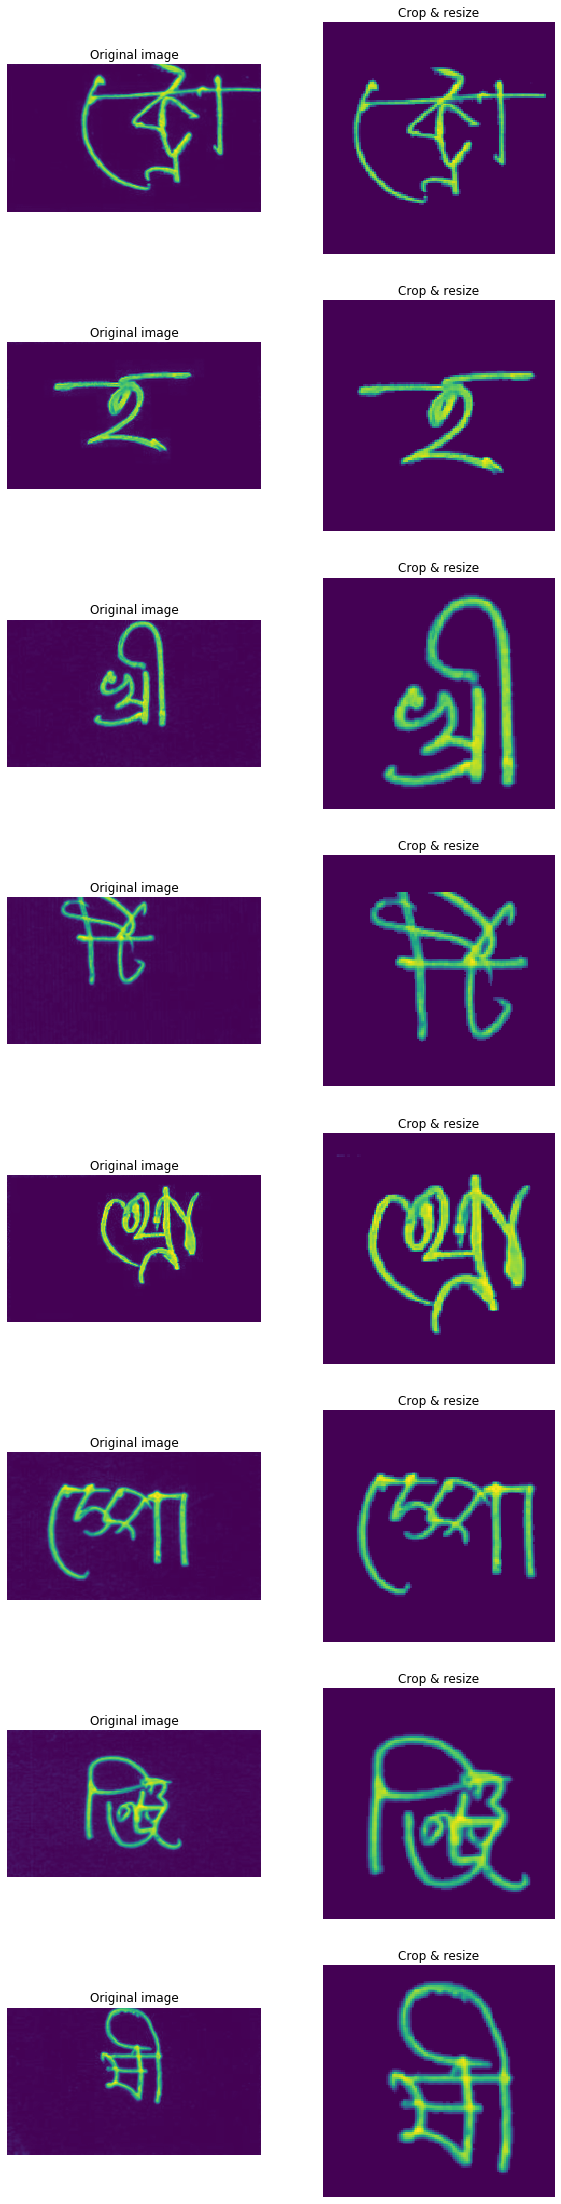

In [0]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(height, width).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

And now we generate the dataset

In [0]:
from tqdm import tqdm

In [0]:
x_tot,x2_tot = [],[]
with ZipFile(out_train, 'w') as img_out:
    for fname in train:
        df = pd.read_parquet('bengaliai/'+fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, height, width).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

100%|██████████| 50210/50210 [02:08<00:00, 390.88it/s]


We're finally going to use our own mean and standard deviation for normalizing:

In [0]:
mean = np.array(x_tot).mean()
std = np.sqrt(np.array(x2_tot).mean() - mean**2)
print(f'mean: {mean}, std: {std}')

mean: 0.06922848809290576, std: 0.20515700083327537


From here we can begin using `fastai2`

# Building the `DataBlock`

In [0]:
with ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall('images')

In [0]:
!pip install scikit-learn fastai2 fastdot

In [0]:
from fastai2.vision.all import *

Out of the three/four csv files that came with it, we care about `train.csv`

In [0]:
train = pd.read_csv('bengaliai/train.csv')
test = pd.read_csv('bengaliai/test.csv')
class_map = pd.read_csv('bengaliai/class_map.csv')

In [0]:
train.head()

image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো

First we need to know how many possible outcomes there can be. We can do this by grabbing the `.unique()` attribute from our dataframe

In [0]:
graph_vocab = train['grapheme_root'].unique()
vowel_vocab = train['vowel_diacritic'].unique()
const_vocab = train['consonant_diacritic'].unique()

And now we generate our `DataBlocks`. We want one for our input (a B/W 2D image), and three `CategoryBlock`'s for our outcomes, each with our pre-determined vocabularies

In [0]:
blocks = (ImageBlock(cls=PILImageBW),
          CategoryBlock(vocab=graph_vocab), 
          CategoryBlock(vocab=vowel_vocab), 
          CategoryBlock(vocab=const_vocab))

Our four getters:

In [0]:
getters = [
           ColReader('image_id', pref='images/', suff='.png'),
           ColReader('grapheme_root'),
           ColReader('vowel_diacritic'),
           ColReader('consonant_diacritic')
]

And some transforms. We're going to use our `mean` and `std` from earlier

In [0]:
batch_tfms = [*aug_transforms(do_flip=False, size=128), 
              Normalize.from_stats(mean=0.0692, std=0.2051)]

Finally making our `DataBlock`. We also should declare that only the first of our blocks is our input

In [0]:
bengel = DataBlock(blocks=blocks, 
                   getters = getters,
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms,
                   n_inp=1)

In [0]:
bs=128

For the dataset itself, since it takes a long time to train, we'll use a 1,000 size sample

In [0]:
dls  = bengel.dataloaders(train.sample(1000), bs=bs)

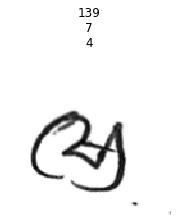

In [0]:
dls.show_batch(max_n=1, figsize=(3,3))

# Custom Heads

For our task, we'll want three custom heads. Let's look at what their outputs need to be:

In [0]:
n = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].nunique(); print(n)

grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
dtype: int64


In [0]:
dls.c

(#3) [168,11,7]

For the body of our model, we'll use a standard resnet34. We need to modify the first `ConvLayer` so that it accepts a 1D image. There are a few ways to go about this. I chose this particular method:

In [0]:
body = create_body(resnet34, pretrained=True)

In [0]:
l = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2),
                    padding=(3,3), bias=False)
l.weight = nn.Parameter(l.weight.sum(dim=1, keepdim=True))

In [0]:
body[0] = l

### Helper Functions

In [0]:
from fastdot import *

In [0]:
def _fillcolor(o:str):
  if 'Lin' in o:
    return 'lightblue'
  elif 'ReLU' in o:
    return 'gray'
  elif 'Flatten' in o:
    return 'white'
  elif 'Pooling' in o:
    return 'pink'
  elif 'Conv' in o:
    return 'white'
  else:
    return 'gold'

node_defaults['fillcolor'] = _fillcolor

In [0]:
graph = ['2DPooling', 'Flatten', 'Lin (1024, 512)', 'ReLU', 'Lin (512, 168)']
vow = ['2DPooling', 'Flatten', 'Lin (1024, 512)', 'ReLU', 'Lin (512, 11)']
const = ['2DPooling', 'Flatten', 'Lin (1024, 512)', 'ReLU', 'Lin (512, 7)']
body1 = ['Conv2d (3, 512, 512)']
out = ['G (bs, 168)\n V (bs,   11)\n C (bs,    7)']
block1, block2, block3, block4, block5 = ['ResNet Body', 'Grapheme Head', 'Vowel Head', 'Consonant Head', 'Model Output']
conns = ((block1, block2),
        (block1, block3),
        (block1, block4),
        (block4, block5),
        (block3, block5),
        (block2, block5),
        (graph[-3], graph[4]),
        (vow[-3], vow[4]),
        (const[-3], const[4]))
visual = graph_items(seq_cluster(body1, block1),
                seq_cluster(graph, block2),
                seq_cluster(vow, block3),
                seq_cluster(const, block4),
                seq_cluster(out, block5))
visual.add_items(*object_connections(conns))

(#9) [<pydot.Edge object at 0x7fd065ec4748>,<pydot.Edge object at 0x7fd065f11a20>,<pydot.Edge object at 0x7fd065ec4be0>,<pydot.Edge object at 0x7fd065fd95c0>,<pydot.Edge object at 0x7fd065f25be0>,<pydot.Edge object at 0x7fd065f2ba58>,<pydot.Edge object at 0x7fd065eda160>,<pydot.Edge object at 0x7fd065eb3748>,<pydot.Edge object at 0x7fd065ede7b8>]

### Visualizing MultiModel Head

And now let's take a look at the head of the model we plan on making, with some assistance from the `fastdot` library (if you want to see how I do this, look at the `Helper Functions` section

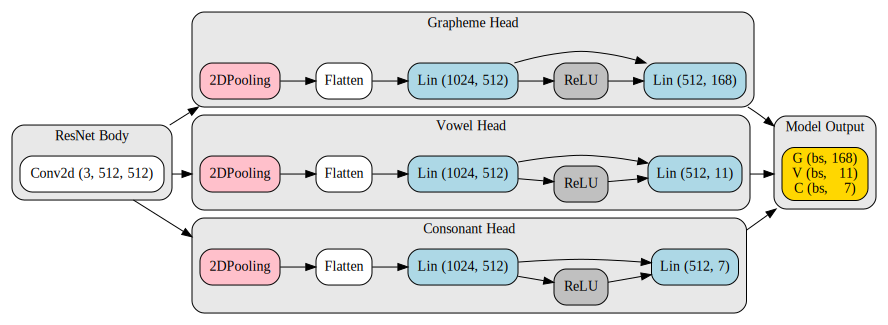

In [0]:
visual

In [0]:
from fastai2.vision.all import *

In [0]:
class MultiModel(Module):
  "A three-headed model given a `body` and `n` output features"
  def __init__(self, body:nn.Sequential, n:L):
    nf = num_features_model(nn.Sequential(*body.children())) * (2)
    self.body = body
    self.grapheme = create_head(nf, n[0])
    self.vowel = create_head(nf, n[1])
    self.consonant = create_head(nf, n[2])
  
  def forward(self, x):
    y = self.body(x)
    graph = self.grapheme(y)
    vowel = self.vowel(y)
    const = self.consonant(y)
    return [graph, vowel, const]

In [0]:
net = MultiModel(body, dls.c)

# Training

We're going to want a custom loss function here. We'll base it on Miguel Pinto's notebook [here](https://www.kaggle.com/mnpinto/bengali-ai-fastai2-starter-lb0-9598). 

In [0]:
from sklearn.metrics import recall_score

In [0]:
class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    def __init__(self, func=F.cross_entropy, weights=[2, 1, 1]):
        self.func, self.w = func, weights

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
            if i == 0: loss = w*self.func(x, y, reduction=reduction) 
            else: loss += w*self.func(x, y, reduction=reduction) 
        return loss

In [0]:
class RecallPartial(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, a=0, **kwargs):
        self.func = partial(recall_score, average='macro', zero_division=0)
        self.a = a

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        pred = learn.pred[self.a].argmax(dim=-1)
        targ = learn.y[self.a]
        pred,targ = to_detach(pred),to_detach(targ)
        pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        return self.func(targs, preds)

    @property
    def name(self): return train.columns[self.a+1]
    
class RecallCombine(Metric):
    def accumulate(self, learn):
        scores = [learn.metrics[i].value for i in range(3)]
        self.combine = np.average(scores, weights=[2,1,1])

    @property
    def value(self):
        return self.combine

Finally we'll declare our model:

In [0]:
learn = Learner(dls, net, loss_func=CombinationLoss(),
                metrics=[RecallPartial(a=i) for i in range(len(dls.c))] + [RecallCombine()],
                )

And train for a few epochs!

In [0]:
learn.fit_one_cycle(10, 1e-3)

# 07 - SuperResolution and GAN's

## What is a GAN?
The Generative Adversarial Network was invented by Ian Goodfellow, where two networks play a game. In our case, we will build a 'crappifier' to make images worse, and the critic will try to determine which is fake and which is the original. This will help us achieve super-resolution

In [0]:
# Run once per session
!pip install fastai2

In [0]:
from fastai2.vision.all import *
from fastai2.vision.gan import *

# Crappified data

Let's build a function first that will go through and 'crappify' some data:

In [0]:
from PIL import ImageDraw, ImageFont

In [0]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [0]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

And now let's get some data to work with. We'll use the `PETS` dataset:

In [0]:
path = untar_data(URLs.PETS)

We'll make two folders, one for the low resolution (LR) and high resolution (HR) photos:

In [0]:
path_hr = path/'images'
path_lr = path/'crappy'

Now let's generate our dataset!

In [0]:
items = get_image_files(path_hr)

In [0]:
parallel(Crappifier(path_lr, path_hr), items);

Let's take a look at one of our generated images:

In [0]:
bad_im = get_image_files(path_lr)

In [0]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

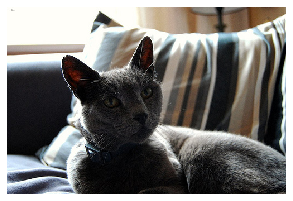

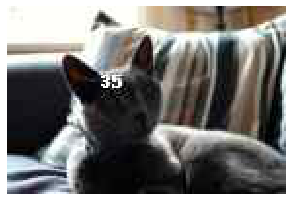

In [0]:
im1.show(); im2.show(figsize=(5,5))

Great! We have some data now! Let's build the `DataBlock`

# DataBlock

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

But for today's lesson, we'll go back to that progressive resizing technique we talked about. We want a function that can accept a `batch_size` and a `im_size`. Let's build that:

In [0]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

# Pre-Trained Generator

The goal of this model will be to generate our "Super Resolution" images (or to make an image look better)

In [0]:
dls_gen = get_dls(32, 128)

On the left will be our 'crappified' image, and the right our original

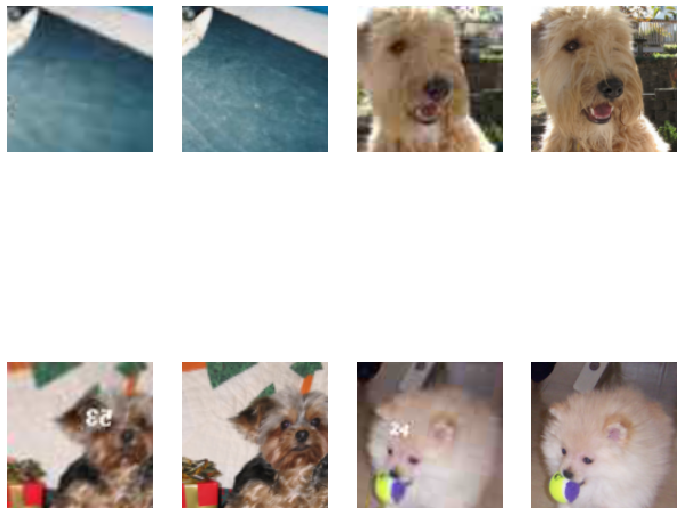

In [0]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

Now let's build some models (with recommended hyper-parameters)

In [0]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

For our backbone, we'll use a resnet34

In [0]:
bbone = resnet34
cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
                  y_range=y_range)

In [0]:
def create_gen_learner():
  return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                      config=cfg)

In [0]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Let's fit our model quickly (we don't need to train for very long)

In [0]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

Let's unfreeze and fit a bit more!

In [0]:
learn_gen.unfreeze()

In [0]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

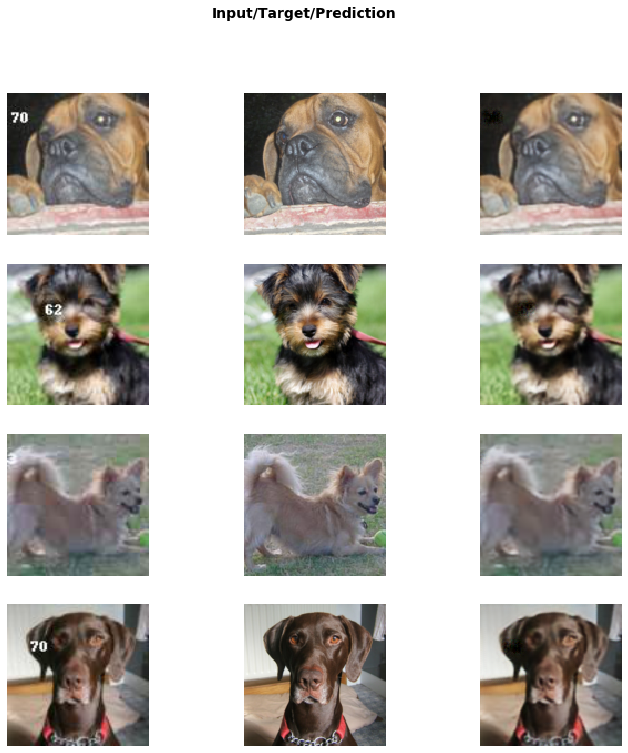

In [0]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [0]:
learn_gen.save('gen-pre2')

# Save the generated images

Now we need these generated images saved away so we can use them for our `critic` model. Let's do so:

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items
  
  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

We'll want to get rid of any augmentation, `drop_last`, and `shuffle` from our training `DataLoader`:

In [0]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Now let's look at what we're actually doing

In [0]:
preds, _ = learn_gen.get_preds(dl=dl)

In [0]:
preds[0].shape

torch.Size([3, 128, 128])

In [0]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [0]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [0]:
arr = dec.numpy().transpose(1,2,0)

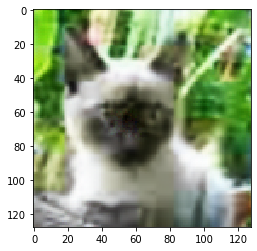

In [0]:
plt.imshow(arr.astype(np.uint8))

Now let's go save it away. 

In [0]:
save_preds(dl, learn_gen)

# Training the critic

Now let's build our critic model

In [0]:
path_gen

Path('/root/.fastai/data/oxford-iiit-pet/image_gen')

In [0]:
name_gen

'image_gen'

In [0]:
# We have to do this because of a bug for right now
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'images')
fnames = path_g + path_i

In [0]:
fnames[0]

Path('/root/.fastai/data/oxford-iiit-pet/image_gen/english_setter_103.jpg')

In [0]:
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [0]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

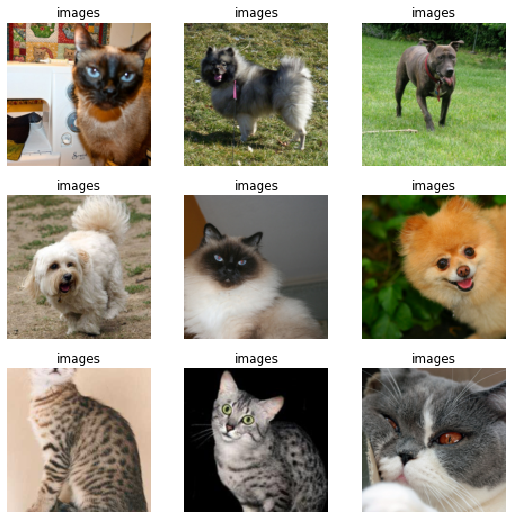

In [0]:
dls_crit.show_batch()

In [0]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [0]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

And now let's fit!

In [0]:
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

In [0]:
learn_crit.save('critic-pre2')

# The GAN

Now we'll combine the two models together into a gan

In [0]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

In [0]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

The last thing to do is to define our GAN. We are going to do this from_learners, and specifiy which is the generator and which is the critic. The switcher is a callback that decides **when to switch from one to another**.

Here, we will do as many iterations of the discrimitor as needed until its loss is back to <0.65 then do an iteration of generator.

The loss function of the critic is learn_crit's loss function. We take the average on the batch of real (targ 1) and fake (targ 0) predictions.

The loss function of the generator is a weighted sum of the learn_crit.loss_func on the **fake** image batch with a target of 1, and learn_gen.loss_func is applied to the output and target, batch of fake and batch of super-res images.

In [0]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

Let's make our switcher and the `GANLearner`

In [0]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [0]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [0]:
lr = 1e-4

And fit!

In [0]:
learn.fit(10, lr, wd=wd)

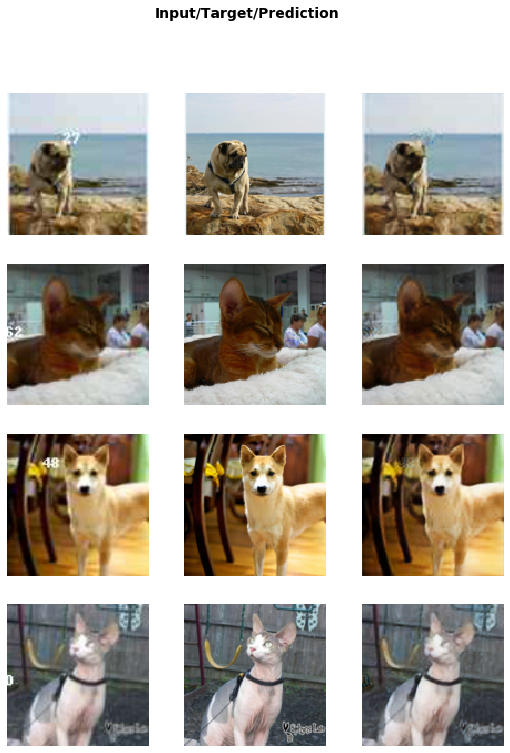

In [0]:
learn.show_results(max_n=4)